# Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clustering

**Introduction: Classification *vs* Clustering**

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

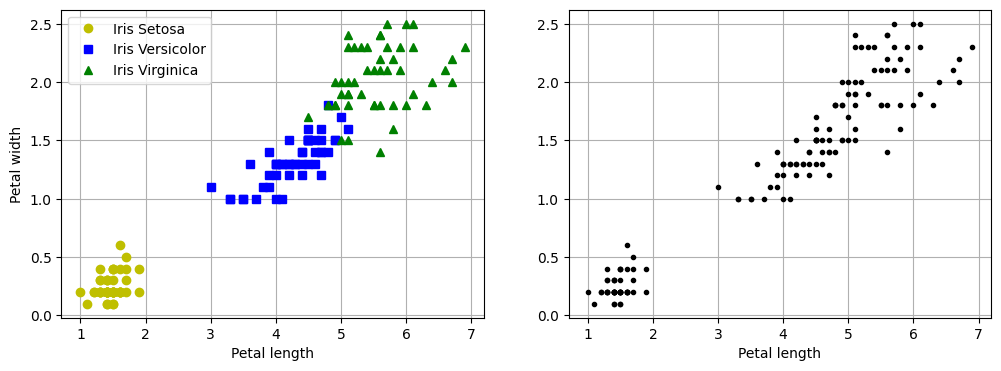

In [3]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(X[:, 2][y == 0], X[:, 3][y == 0], "yo", label="Iris Setosa")
plt.plot(X[:, 2][y == 1], X[:, 3][y == 1], "bs", label="Iris Versicolor")
plt.plot(X[:, 2][y == 2], X[:, 3][y == 2], "g^", label="Iris Virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(X[:, 2], X[:, 3], "k.")
plt.xlabel("Petal length")
plt.grid()

plt.show()

**Note:** The next code cell shows how a Gaussian Mixture model (explained later in this notebook) can actually these clusters quite well using all 4 features: petal length and width, sepal length and width.   

In [4]:
from sklearn.mixture import GaussianMixture

y_predict = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Next, we map each cluster to a class. Each cluster will have a unique id and here we try to map the cluster's id to the class in the dataset. Instead of hard coding the mapping, we will use `scipy.stats.mode()` function.

In [5]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_predict[y == class_id])
    mapping[mode] = class_id

Then we transform the predicted array to use the class in the dataset, instead of its self-created id, and plot the result.

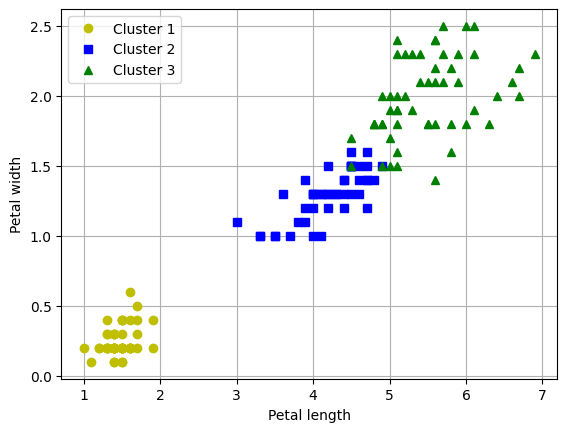

In [6]:
y_predict = np.array([mapping[cluster_id] for cluster_id in y_predict])

plt.plot(X[y_predict == 0, 2], X[y_predict == 0, 3], "yo", label="Cluster 1")
plt.plot(X[y_predict == 1, 2], X[y_predict == 1, 3], "bs", label="Cluster 2")
plt.plot(X[y_predict == 2, 2], X[y_predict == 2, 3], "g^", label="Cluster 3")
plt.grid()
plt.legend()
plt.xlabel("Petal length")
plt.ylabel("Petal width")

plt.show()

What's the ratio of iris plant we assigned to the right cluster?

In [7]:
(y_predict == y).sum() / len(y)

0.9666666666666667

And we only misclassify 5 of them.

In [8]:
len(y) - (y_predict == y).sum()

5

## K-means

**Fit and predict**

Here, we train a K-means clustering algorithm on a dataset of blobs. It will try to find the centroid of each blob and assign each instance to the closet blob.

In [3]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]]
)
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(
    n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7
)

Here, `random_state` is set to 1, to ensure that the centroids will be at the blob centers. The detail will be explained further as you go.

In [10]:
k = 5
k_means = KMeans(n_clusters=k, n_init=10, random_state=1)
y_predict = k_means.fit_predict(X)

Then we will plot them.

In [11]:
def plot_cluster(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

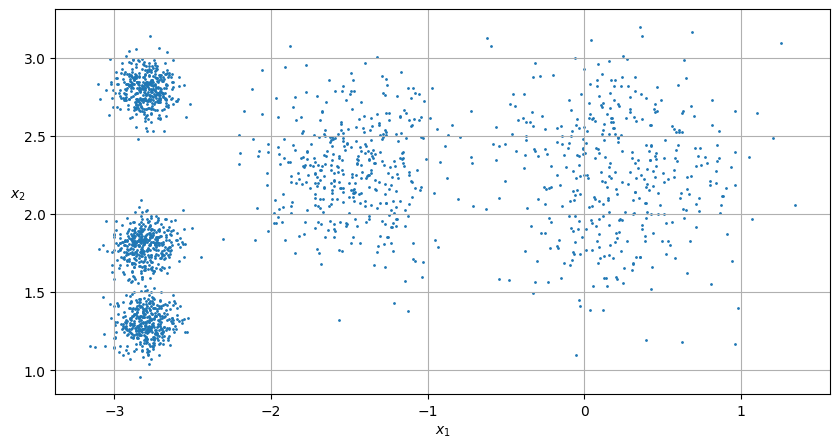

In [12]:
plt.figure(figsize=(10, 5))
plot_cluster(X)
plt.grid()

plt.show()

Each instance is assigned to one of the 5 clusters.

In [13]:
y_predict

array([1, 4, 0, ..., 3, 0, 4], dtype=int32)

In [14]:
y_predict is k_means.labels_

True

The following 5 centroids (i.e. cluster centers) were estimated as:  

In [15]:
k_means.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80037642,  1.30082566],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80389616,  1.80117999]])

Note that `KMeans` preserves the label of each instance it was trained on. This label is the index of the cluster it belongs to, not to be confused with the labels in the training set. 

In [16]:
k_means.labels_

array([1, 4, 0, ..., 3, 0, 4], dtype=int32)

Of course, we can predict the cluster new instances may belong to. 

In [17]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
k_means.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

**Decision boundaries**

In [2]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)

In [3]:
def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="o",
        s=35,
        linewidths=8,
        color=circle_color,
        zorder=10,
        alpha=0.9,
    )
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=2,
        linewidths=12,
        color=cross_color,
        zorder=11,
        alpha=1,
    )

In [4]:
def plot_decision_boundaries(
    clusterer,
    X,
    resolution=1000,
    show_centroids=True,
    show_xlabels=True,
    show_ylabels=True,
):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution),
    )
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(
        Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k"
    )
    plot_data(X)

    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)

    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

The result is a *Voronoi* diagram.

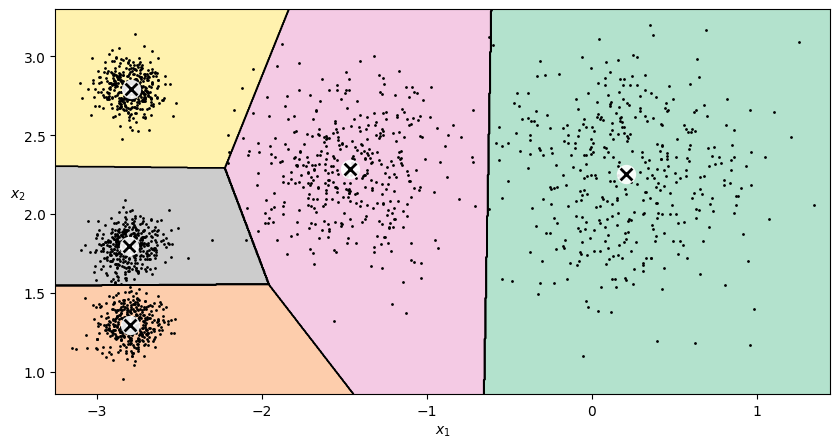

In [21]:
plt.figure(figsize=(10, 5))
plot_decision_boundaries(k_means, X)
plt.show()

Great! Some instances along the edge may be assigned to the wrong cluster, but in general, our model work very good.

**Hard Clustering vs Soft Clustering**

Rather than just assign an instance to the closest cluster, which is called *hard clustering*, it could be better to measure the distance to all 5 centroids. This is what the `transform()` method does.

In [22]:
k_means.transform(X_new).round(2)

array([[0.33, 2.89, 1.49, 2.9 , 2.81],
       [2.8 , 5.84, 4.48, 5.85, 5.81],
       [3.29, 1.71, 1.69, 0.29, 1.21],
       [3.22, 1.22, 1.55, 0.36, 0.73]])

You can check that this is in fact the Euclidean distance between each instance and each centroid.

In [23]:
np.linalg.norm(
    np.tile(X_new, (1, k)).reshape(-1, k, 2) - k_means.cluster_centers_, axis=2
).round(2)

array([[0.33, 2.89, 1.49, 2.9 , 2.81],
       [2.8 , 5.84, 4.48, 5.85, 5.81],
       [3.29, 1.71, 1.69, 0.29, 1.21],
       [3.22, 1.22, 1.55, 0.36, 0.73]])

### The K-Means algorithm

The K-means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
- First, initialize *k* centroids randomly. Which means select k distinct instances randomly from the dataset and places the centroids at their instances' locations.
- Repeat until converges (i.e. until the centroids stop moving):
    - Assign each instances to the closest centroid.
    - Update the centroids to be the mean of all the instances assigned to them.

The `KMeans` class uses an optimized initialization technique by default. To use the original K-Means algorithm (for educational purpose only, as it is subjectively worse than the default one), you must set `init=random` and `n_init=1`. More on that later on this chapter.

Here, we will run the K-means algorithm for 1, 2 and 3 iterations and see how the centroids move around.

In [24]:
k_means_iter1 = KMeans(
    n_clusters=5, init="random", n_init=1, max_iter=1, random_state=1
)
k_means_iter2 = KMeans(
    n_clusters=5, init="random", n_init=1, max_iter=2, random_state=1
)
k_means_iter3 = KMeans(
    n_clusters=5, init="random", n_init=1, max_iter=3, random_state=1
)
k_means_iter1.fit(X)
k_means_iter2.fit(X)
k_means_iter3.fit(X)

KMeans(init='random', max_iter=3, n_clusters=5, n_init=1, random_state=1)

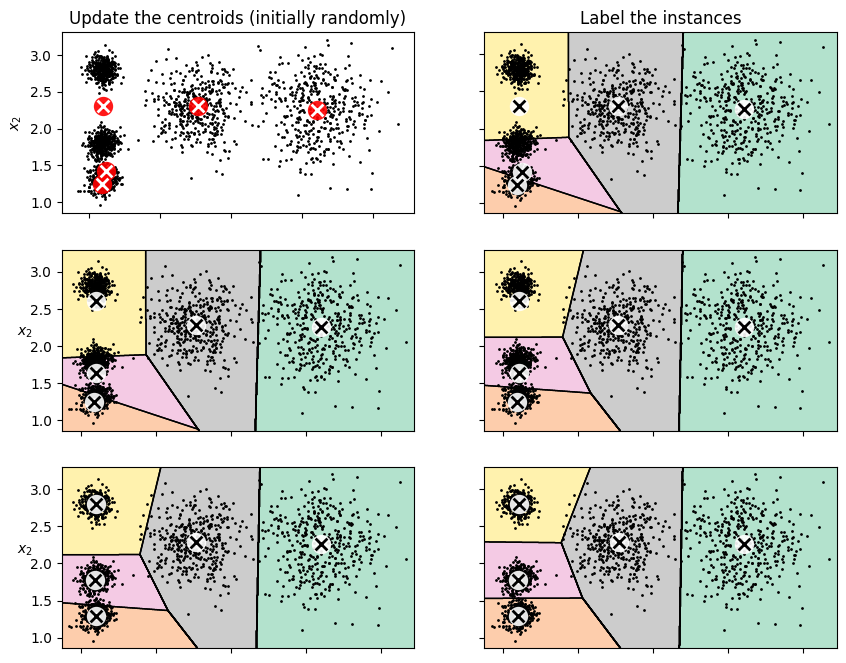

In [25]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(k_means_iter1.cluster_centers_, circle_color="r", cross_color="w")
plt.ylabel("$x_2$")
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(k_means_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(k_means_iter1, X, show_xlabels=False, show_centroids=False)
plot_centroids(k_means_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(k_means_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(k_means_iter2, X, show_xlabels=False, show_centroids=False)
plot_centroids(k_means_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(k_means_iter3, X, show_xlabels=False, show_ylabels=False)

There is one downside of the original K-means algorithm: If you run K-means multiple times (with different random seeds), each time the model can converge to different solution. That means the model could be a suboptimal solution.

In [26]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X)
    if title1:
        plt.title(title2)

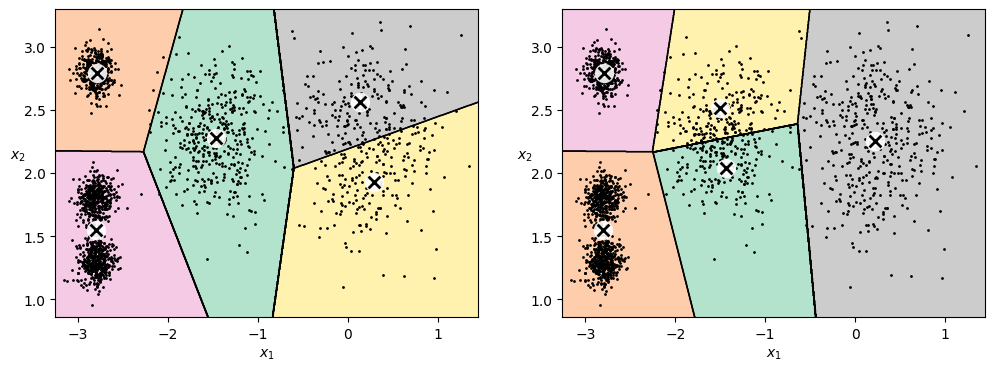

In [27]:
k_means_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
k_means_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=5)

plot_clusterer_comparison(k_means_rnd_init1, k_means_rnd_init2, X)
plt.show()

In [28]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
k_means = KMeans(n_clusters=5, n_init=1, init=good_init, random_state=42)
k_means.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

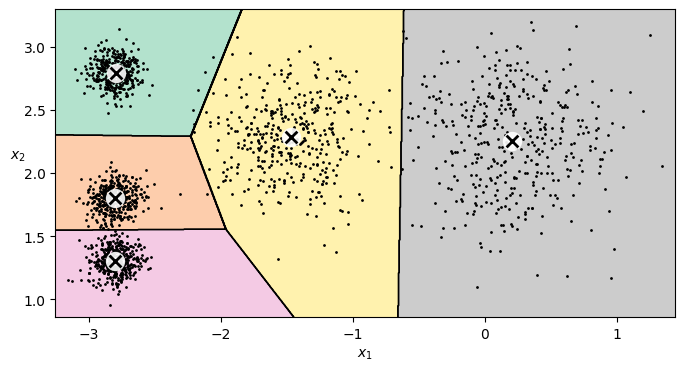

In [29]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(k_means, X)

### Inertia

You can access the inertia of a model via the `inertia_` attribute.

In [30]:
k_means.inertia_

211.59853725816836

In [31]:
k_means_rnd_init1.inertia_

219.58201503602288

In [32]:
k_means_rnd_init2.inertia_

239.19226403410454

As you can easily verify, inertia is the sum of all squared distance between each training instances and its closest centroids.

In [33]:
X_distance = k_means.transform(X)
(X_distance[np.arange(len(X_distance)), k_means.labels_] ** 2).sum()

211.5985372581688

The `score()` method returns the negative inertia. Why negative? Because a predictor's `score()` method must always respect the "*greater is better*" rule.

In [34]:
k_means.score(X)

-211.59853725816836

### Multiple Initializations

One approach to solve this variability issue is to simply run the K-means algorithm several times with different random initializations, and select the solution that minimizes the inertia.

When you set the `n_init` hyperparameter, Scikit-learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-learn sets `n_init=10`.

In [35]:
k_means_rnd_10_init = KMeans(n_clusters=5, init="random", n_init=10, random_state=42)
k_means_rnd_10_init.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=42)

As you can see, we end up with the initial model, which is certainly the optimal K-means solution (at least in term of inertia, and assuming $k = 5$).

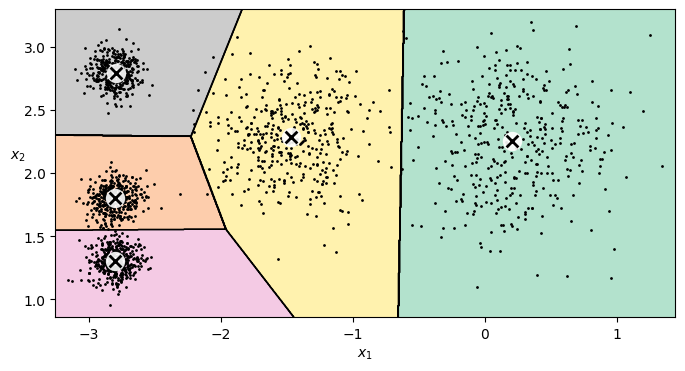

In [36]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(k_means_rnd_10_init, X)

In [37]:
k_means_rnd_10_init.inertia_

211.59853725816834

In Scikit-learn, we actually uses K-Means++ as the default algorithm for centroids initialization. If you want to specifically set to K-Means, set `init="k-means++"`.

### Accelerated K-Means and Mini-batch K-means

If you want to use accelerated K-means, set `algorithm="elkan"`. For regular KMeans, use `algorithm="llyod"`. More explanation about the Elkan's algorithm can be seen in note.md.

Scikit-learn also implements a variant of the K-means that supports mini-batches.

In [38]:
from sklearn.cluster import MiniBatchKMeans

mini_batch_k_means = MiniBatchKMeans(n_clusters=5, n_init=3, random_state=42)
mini_batch_k_means.fit(X)

MiniBatchKMeans(n_clusters=5, n_init=3, random_state=42)

In [39]:
mini_batch_k_means.inertia_

211.65899374574315

**Using `MiniBatchKMeans` along with `memmap`** (not in the book)

If the dataset does not fit in the memory, the simplest option is to use the `memmap` class, like we did for incremental PCA in the previous chapter. First let's load MNIST.

In [40]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False, parser="auto")

Let's split the dataset.

In [41]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

Now, let's write the training set to a `memmap`.

In [42]:
X_memmap = np.memmap(
    filename="my_mnist.mmap", dtype="float32", mode="write", shape=X_train.shape
)
X_memmap[:] = X_train
X_memmap.flush()

In [43]:
from sklearn.cluster import MiniBatchKMeans

mini_batch_k_means = MiniBatchKMeans(
    n_clusters=10, batch_size=10, n_init=3, random_state=42
)
mini_batch_k_means.fit(X_memmap)

MiniBatchKMeans(batch_size=10, n_clusters=10, n_init=3, random_state=42)

Here, I plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means. 

In [44]:
from timeit import timeit

max_k = 100
times = np.empty((max_k, 2))
inertias = np.empty((max_k, 2))
for k in range(1, max_k + 1):
    k_means_ = KMeans(n_clusters=k, algorithm="lloyd", n_init=10, random_state=42)
    mini_batch_k_means_ = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
    print(f"\r{k}/{max_k}", end="")  # \r returns the start of the line
    times[k - 1, 0] = timeit("k_means_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("mini_batch_k_means_.fit(X)", number=10, globals=globals())

    inertias[k - 1, 0] = k_means_.inertia_
    inertias[k - 1, 1] = mini_batch_k_means_.inertia_

100/100

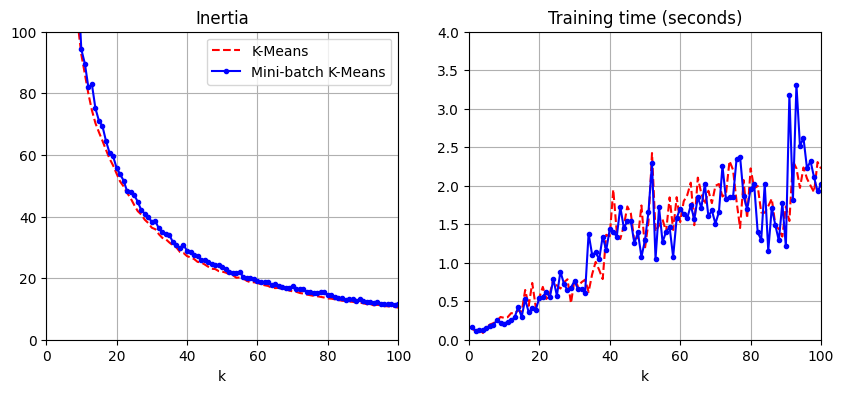

In [45]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, max_k + 1), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.legend()
plt.xlabel("k")
plt.title("Inertia")
plt.grid()
plt.axis([0, max_k, 0, 100])

plt.subplot(122)
plt.plot(range(1, max_k + 1), times[:, 0], "r--")
plt.plot(range(1, max_k + 1), times[:, 1], "b.-")
plt.xlabel("k")
plt.title("Training time (seconds)")
plt.grid()
plt.axis([0, max_k, 0, 4])

plt.show()

### Finding the optimal number of clusters

What if the number of cluster was set to a number lower or greater than 5?

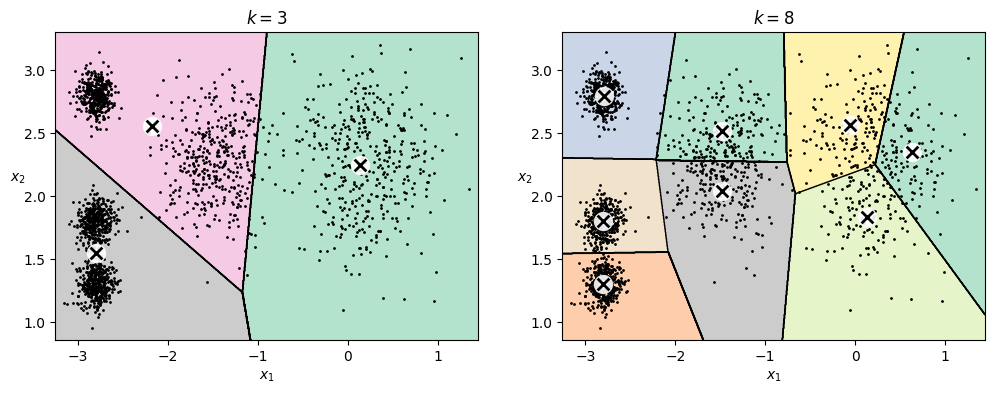

In [46]:
k_means_k3 = KMeans(n_clusters=3, n_init=10, random_state=42)
k_means_k8 = KMeans(n_clusters=8, n_init=10, random_state=42)

plot_clusterer_comparison(k_means_k3, k_means_k8, X, "$k=3$", "$k=8$")
plt.show()

Well, these 2 models don't work so great. What about their inertias?

In [47]:
k_means_k3.inertia_

653.2167190021553

In [48]:
k_means_k8.inertia_

119.22484592677122

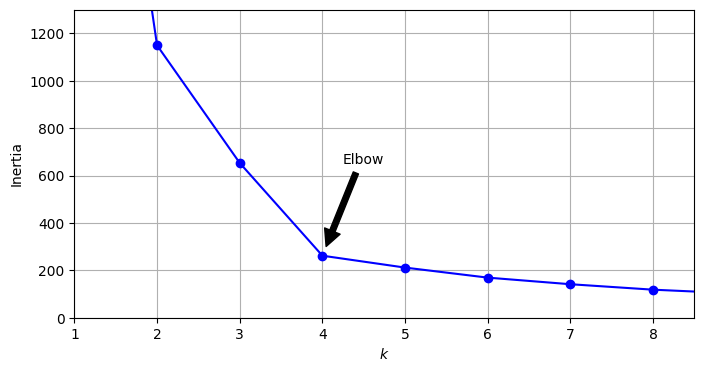

In [49]:
k_means_per_k = [
    KMeans(n_clusters=k, n_init=10, random_state=1).fit(X) for k in range(1, 10)
]
inertias = [model.inertia_ for model in k_means_per_k]

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate(
    "",
    xy=(4, inertias[3]),
    xytext=(4.45, 650),
    arrowprops=dict(facecolor="black", shrink=0.1),
)
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
plt.show()

Let's plot the silhouette as a function of *k*.

In [50]:
from sklearn.metrics import silhouette_score

silhouette_score(X, k_means.labels_)

0.655517642572828

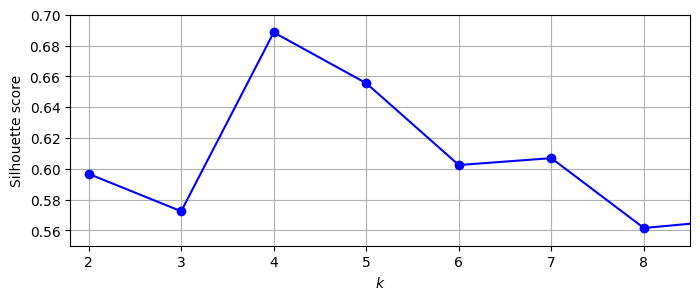

In [51]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in k_means_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid()
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

There's even a more informative visualization way: We plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a *silhouette diagram*.

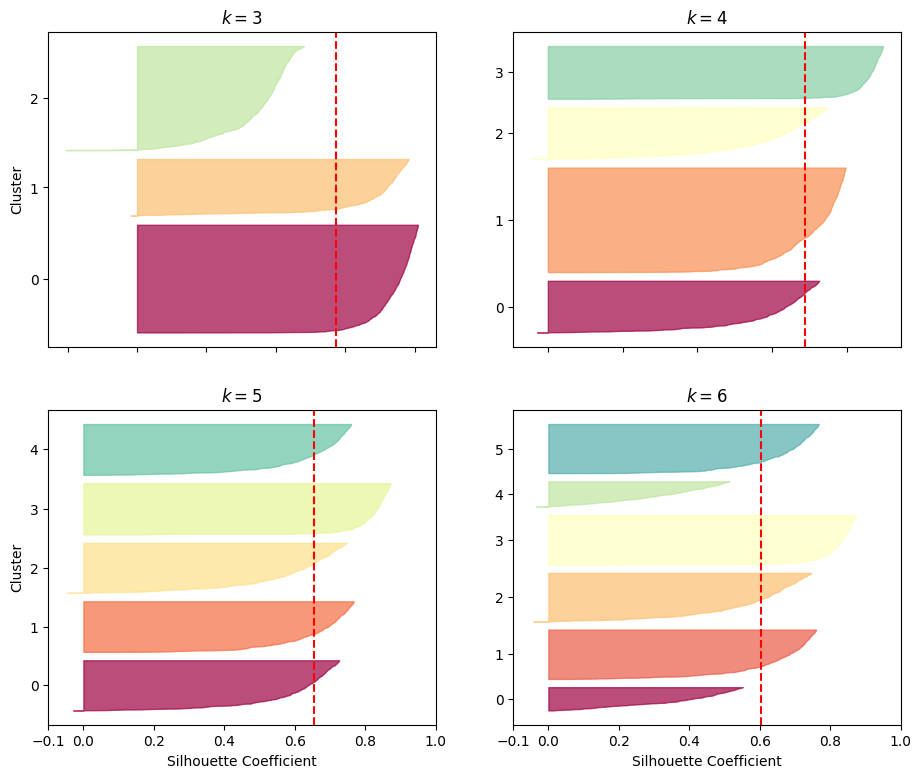

In [52]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedFormatter, FixedLocator

plt.figure(figsize=(11, 9))

for k in [3, 4, 5, 6]:
    plt.subplot(2, 2, k - 2)

    y_predict = k_means_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_predict)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coefficients: np.ndarray = silhouette_coefficients[y_predict == i]
        coefficients.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(
            np.arange(pos, pos + len(coefficients)),
            0,
            coefficients,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ticks.append(pos + len(coefficients) // 2)
        pos += len(coefficients) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in [3, 5]:
        plt.ylabel("Cluster")
    if k in [5, 6]:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

## Limits of K-Means

Here we create a more difficult dataset, with elongated blobs and and varying densities, and shows how K-Means struggles to cluster it properly.

In [53]:
X1, y1 = make_blobs(n_samples=1000, centers=[(4, -4), (0, 0)], random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [54]:
k_means_good = KMeans(
    n_clusters=3, init=np.array([[-2, 2], [0, 0], [4, 0]]), n_init=1, random_state=42
)
k_means_bad = KMeans(n_clusters=3, n_init=10, random_state=42)
k_means_good.fit(X)
k_means_bad.fit(X)

KMeans(n_clusters=3, n_init=10, random_state=42)

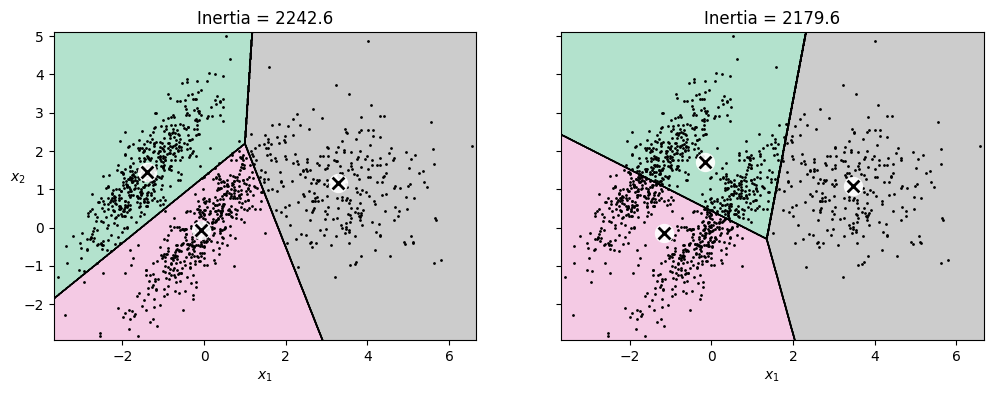

In [55]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_decision_boundaries(k_means_good, X)
plt.title(f"Inertia = {k_means_good.inertia_:.1f}")

plt.subplot(122)
plot_decision_boundaries(k_means_bad, X, show_ylabels=False)
plt.title(f"Inertia = {k_means_bad.inertia_:.1f}")

plt.show()

## Using Clustering for Image Segmentation

Download the ladybug image:

In [56]:
import urllib.request
from pathlib import Path

url_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
filepath = Path() / filename
if not filepath.is_file():
    print("Downloading", filename)
    url = f"{url_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

In [57]:
import PIL

image = np.asarray(PIL.Image.open(filepath))
image.shape

(533, 800, 3)

We reshape the array to get a long list of RGB colors, then cluster theses colors using k-means with eight clusters. It creates a `segmented_img` array containing the nearest cluster for each pixel (i.e. the mean color of each pixel's cluster), and lastly it reshapes this array to the original image shape. The third line uses advanced NumPy indexing: For example, if the first 10 labels in `k_means.labels_` is equal to 1, then the first 10 colors in `segmented_img` are equal to `k_means.cluster_centers_[1]`.

In [58]:
X = image.reshape(-1, 3)
k_means = KMeans(n_clusters=8, n_init=10, random_state=42).fit(X)
segmented_img = k_means.cluster_centers_[k_means.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [59]:
segmented_imgs = []
n_colors = [10, 8, 6, 4, 2]
for n_cluster in n_colors:
    k_means_ = KMeans(n_clusters=n_cluster, n_init=10, random_state=42).fit(X)
    segmented_img = k_means_.cluster_centers_[k_means_.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

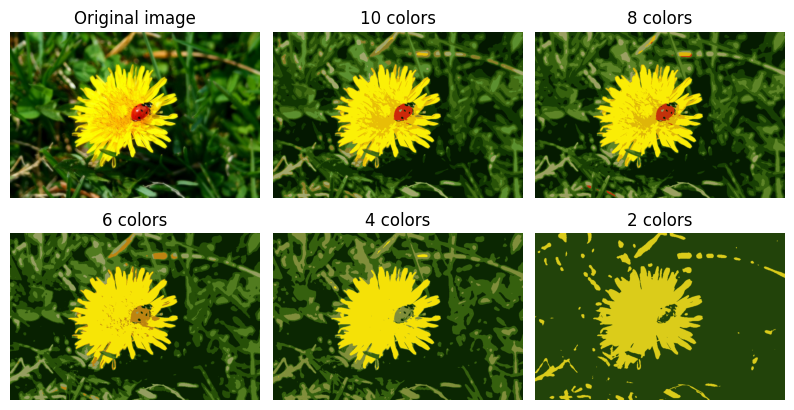

In [60]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis("off")

for idx, n_cluster in enumerate(n_colors):
    plt.subplot(2, 3, idx + 2)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_cluster} colors")
    plt.axis("off")

plt.show()

## Using Clustering for Semi-Supervised Learning  

Let's tackle the *digits dataset*, which is a simple MNIST-like dataset containing 1,797 greyscale 8x8 images representing the digits 0 to 9. 

In [99]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

Let's look at performance of a logistic regression model if we only trained on 50 labeled instances.

In [100]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

We can measure the accuracy of the model on the test set using `score()` function. Note that the test set must be labeled.

In [101]:
log_reg.score(X_test, y_test)

0.7481108312342569

In [102]:
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.906801007556675

That is much less than earlier of the course. Let's see if we can improve it. First, let's cluster the training set into 50 clusters. Then for each cluster, we'll find the image closest to the centroid. We call these images the *presentative images*.

In [103]:
k = 50
k_means = KMeans(n_clusters=k, n_init=50, random_state=42)
X_digits_distance = k_means.fit_transform(X_train)
representative_digit_index = X_digits_distance.argmin(axis=0)
X_representative_digits = X_train[representative_digit_index]

Then we plot and label them manually.

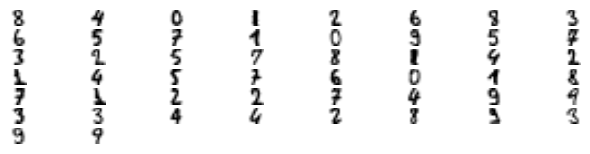

In [92]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(8, 8, index + 1)
    plt.imshow(
        X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear"
    )
    plt.axis("off")
plt.show()

In [104]:
y_representative_digits = np.array(
    [
        8,
        4,
        0,
        1,
        2,
        6,
        8,
        3,
        6,
        5,
        7,
        1,
        0,
        9,
        5,
        7,
        3,
        2,
        5,
        7,
        8,
        1,
        4,
        2,
        1,
        4,
        5,
        7,
        6,
        0,
        1,
        8,
        7,
        1,
        2,
        2,
        7,
        4,
        9,
        9,
        3,
        3,
        4,
        4,
        2,
        8,
        9,
        3,
        9,
        9,
    ]
)

Now we have a dataset with 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better.

In [105]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8564231738035264

Impressive! We jumped from 74.8% accuracy to 85.6%, although we are still only training the model on 50 instances. Since it is often costly and painful to label instances, especially when it has to be done manually by experts, it is a good idea to label representative labels instead of random instances.

But we can go one step further: We propagated the labels to all the other instances in the same cluster.

In [106]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[k_means.labels_ == i] = y_representative_digits[i]

In [107]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=10000)

In [108]:
log_reg.score(X_test, y_test)

0.8413098236775819

We got a drop in accuracy! Let's see if we can do better by ignoring the 1% of instances that are farthest from their cluster centers, as this should eliminate some outliers.

The following code first computes the distance from each cluster to its closest cluster center, then for each cluster, it sets 1% largest distance to -1. Lastly, it creates a set without these instances marked with a -1 distance.

In [109]:
percentile_closest = 99

X_cluster_distance = X_digits_distance[np.arange(len(X_train)), k_means.labels_]
for i in range(k):
    in_cluster = k_means.labels_ == i
    cluster_distance = X_cluster_distance[in_cluster]
    cutoff_distance = np.percentile(cluster_distance, percentile_closest)
    above_cutoff = X_cluster_distance > cutoff_distance
    X_cluster_distance[in_cluster & above_cutoff] = -1

partially_propagated = X_cluster_distance != -1
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [110]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8463476070528967

We do improve the performance compared to the last model, but it is not as high as we just train on the full training set.

Our propagated labels is not so good: Its accuracy is only about 95.8%.

In [111]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

0.9577777777777777

## DBSCAN

In [1]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

The labels of all the instances can be accessed via the `labels_` instance variable.

In [2]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

Notice that some instance have a cluster index equal to -1, which means that they are considered anomalies by the algorithm. The indices of the core instances are available in the `core_sample_indices_` instance variable, and the core instances themselves are available in the `components_` instance variable.

In [3]:
dbscan.core_sample_indices_

array([  0,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,  30,  31,
        32,  33,  34,  36,  38,  39,  41,  42,  44,  45,  47,  49,  50,
        51,  52,  53,  54,  55,  56,  58,  59,  61,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  83,  84,  85,  87,  88,  89,  90,  91,  93,  94,  96,
        97,  98, 102, 103, 104, 105, 106, 107, 108, 109, 110, 113, 114,
       115, 116, 117, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 135, 136, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149,
       150, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178,
       179, 181, 182, 183, 185, 186, 187, 188, 189, 191, 193, 194, 195,
       196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 22

In [4]:
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

In [24]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(anomalies_mask | core_mask)

    cores = dbscan.components_
    non_cores = X[non_core_mask]
    anomalies = X[anomalies_mask]

    plt.scatter(
        cores[:, 0],
        cores[:, 1],
        c=dbscan.labels_[core_mask],
        marker="o",
        s=size,
        cmap="Paired",
    )
    plt.scatter(cores[:, 0], cores[:, 1], marker="*", s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1], c="r", marker="x", s=100)
    plt.scatter(
        non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker="."
    )
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

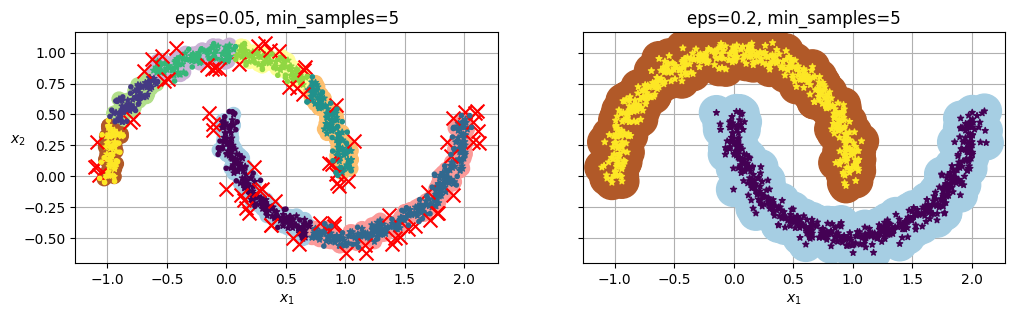

In [27]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(12, 3))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

The clustering on the left plot is disappointed. It identified lots of anomalies (red cross), plus seven different clusters. Luckily, when we increase `eps` to 0.2, we get the model on the right, which looks perfect. Let's proceed with this model.

In [28]:
dbscan = dbscan2

- A weird thing is the `DBSCAN` class doesn't have a `predict()` method, although it does have a `fit_predict()` method. In other words, it cannot predict which cluster a new instance belongs to.
- This decision was made because different different classification algorithms can be better for different tasks, so the authors decide to let the user choose which one to use.
- Moreover, it is simple to implement one. For example, here we train a `KNeighborsClassifier`.

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50, n_jobs=-1)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_jobs=-1, n_neighbors=50)

Now, given a few new instances, we can predict which cluster they most likely belong to and even estimate the probability for each cluster.

In [30]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [31]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Note that we only trained on the core instances, but we can instead train on all instances, or all but the anomalies. This choice depends on the task at hand.

We plot the decision boundary (the cross represent the four instances in `X_new`).

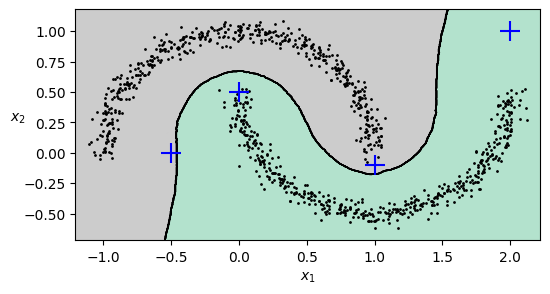

In [40]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], marker="+", s=200, zorder=10, c="b")
plt.show()

Notice that there is no anomaly in this dataset, hence classifier always chooses a cluster, even when that cluster is far away. We will introduce a maximum distance, in which case the instance that is far away form both clusters is considered an anomaly. <br>
To do this, we use the `kneighbors()` method of the `KNeighborsClassifier` class. Given a list of instances, it returns the distance and the indices of the k-nearest neighbors in the training set (two matrices, each with k-columns).

In [41]:
y_distance, y_predict_index = knn.kneighbors(X_new, n_neighbors=1)
y_predict = dbscan.labels_[dbscan.core_sample_indices_][y_predict_index]
y_predict[y_distance > 0.2] = -1
y_predict.ravel()

array([-1,  0,  1, -1])

## Other Clustering Algorithm

### Spectral Clustering

In [2]:
from sklearn.cluster import SpectralClustering

sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [3]:
sc1.affinity_matrix_.round(2)

array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 1. , 0.3, ..., 0. , 0. , 0. ],
       [0. , 0.3, 1. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 1. ]])

In [4]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [7]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=size, c="gray", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=30, c="w")
    plt.scatter(X[:, 0], X[:, 1], marker=".", s=10, c=sc.labels_, cmap="Paired")

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)

    if show_ylabels:
        plt.xlabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

    plt.title(f"RBF gamma={sc.gamma}")

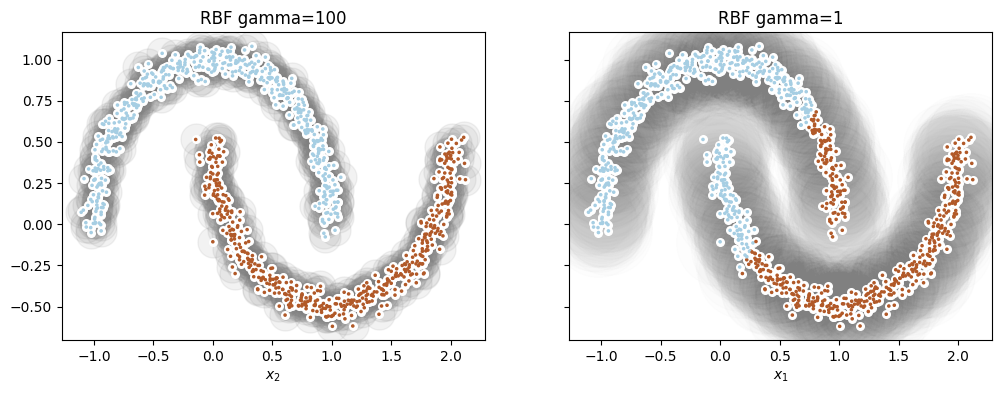

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

### Agglomerative Clustering

In [2]:
from sklearn.cluster import AgglomerativeClustering

X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [3]:
def learned_parameters(estimator):
    return [
        attribute
        for attribute in dir(estimator)
        if attribute.endswith("_") and not attribute.startswith("_")
    ]

In [4]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [5]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

# Gaussian Mixtures

Here we regenerate the dataset with three ellipsoids (the one k-means has trouble with).

In [2]:
from sklearn.datasets import make_blobs

In [3]:
X1, y1 = make_blobs(n_samples=1000, centers=[(4, -4), (0, 0)], random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Now, we train a Gaussian mixture model on this dataset.

In [4]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated.

In [10]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [11]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [12]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

Did the algorithm actually converged?

In [13]:
gm.converged_

True

And how many iterations did it take?

In [14]:
gm.n_iter_

4

You can use `predict()` for hard clustering and `predict_proba()` for soft clustering.

In [15]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1])

In [16]:
gm.predict_proba(X).round(3)

array([[0.   , 0.023, 0.977],
       [0.001, 0.016, 0.983],
       [1.   , 0.   , 0.   ],
       ...,
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ]])

This is a generative model, which means you can sample new instances from it (and get their labels).

In [17]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [18]:
y_new

array([0, 0, 1, 1, 1, 2])

Note that they are sampled sequentially from each cluster.

You can also estimate the log of the *probability density function* (PDF) at any location using the `score_sample()` method.

In [19]:
gm.score_samples(X).round(2)

array([-2.61, -3.57, -3.33, ..., -3.51, -4.4 , -3.81])

Here we check if the integral of PDF is 1 over the whole space. Here is the process:
- We take a large square around the clusters, and chop it into a grid of tiny squares.
- We then compute the approximate probability that the instances will be generated inside each tiny square (by multiplying the PDF of one corner of the tiny square by the area of that square).
- Finally, we sum up all these probabilities.

In [20]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_proba = pdf * (1 / resolution) ** 2
pdf_proba.sum()

0.9999999999225091

We define a function to plot the resulting decision boundaries (red dashed lines) and density contours.

In [21]:
from matplotlib.colors import LogNorm


def plot_gaussian_mixture(clusterer, X: np.ndarray, resolution=1000, show_yalbels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution),
    )
    Z: np.ndarray = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the cluster
    plt.contourf(
        xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12)
    )
    plt.contour(
        xx,
        yy,
        Z,
        norm=LogNorm(vmin=1.0, vmax=30.0),
        levels=np.logspace(0, 2, 12),
        linewidths=1,
        colors="k",
    )

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the decisions boundary
    plt.contour(xx, yy, Z, linewidths=2, linestyles="dashed", colors="r")

    # plot the dataset
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)

    # plot the centroids
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_yalbels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

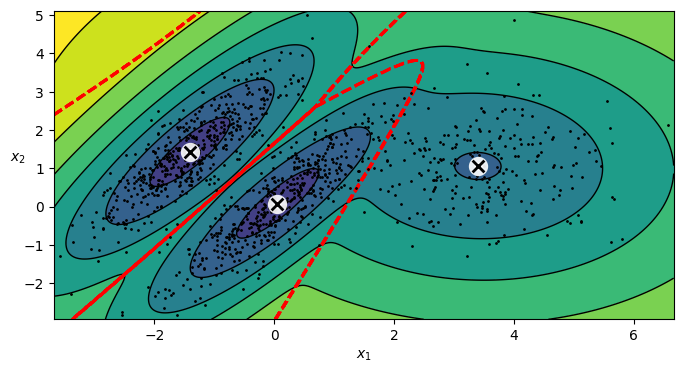

In [22]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

You can impose constraints on the covariance matrices that the algorithm looks for by setting `covariance_type` hyperparameter:
- `"spherical"`: all clusters must be spherical, but they can have different diameters (e.g. variances).
- `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's shape must be parallel to one of the axes (e.g., the covariance matrix must be diagonal).
- `"tied"`: all clusters must have the same shape, which can be any ellipsoid (e.g., they all share the same covariance matrix).
- `"full"`(default): no constraint, all clusters can take on any ellipsoidal shape of any size.

In [23]:
gm_full = GaussianMixture(
    n_components=3, n_init=10, covariance_type="full", random_state=42
)
gm_tied = GaussianMixture(
    n_components=3, n_init=10, covariance_type="tied", random_state=42
)
gm_spherical = GaussianMixture(
    n_components=3, n_init=10, covariance_type="spherical", random_state=42
)
gm_diag = GaussianMixture(
    n_components=3, n_init=10, covariance_type="diag", random_state=42
)

gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [34]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title(f'covariance type="{gm1.covariance_type}"')

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_yalbels=False)
    plt.title(f'covariance type="{gm2.covariance_type}"')

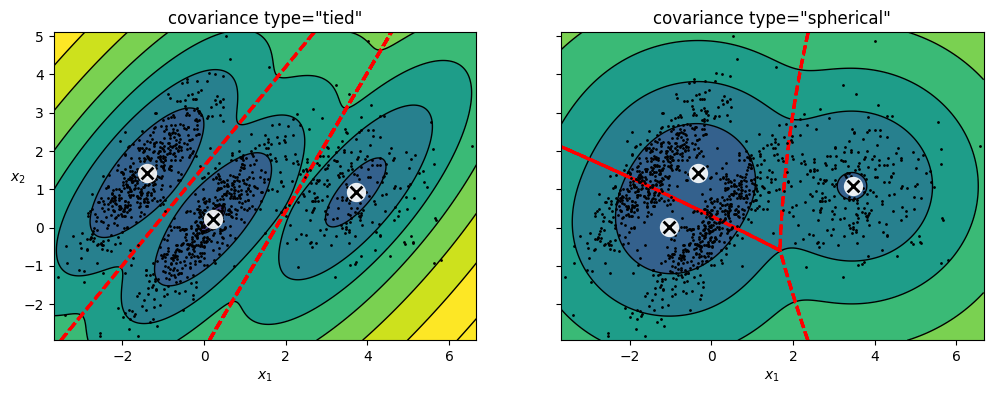

In [35]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

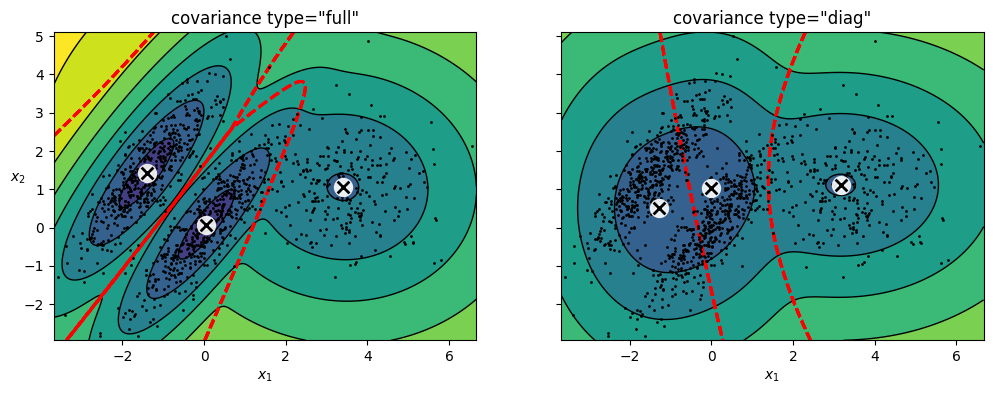

In [36]:
compare_gaussian_mixtures(gm_full, gm_diag, X)

## Anomaly Detection using Gaussian Mixtures

In [37]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 1)
anomalies = X[densities < density_threshold]

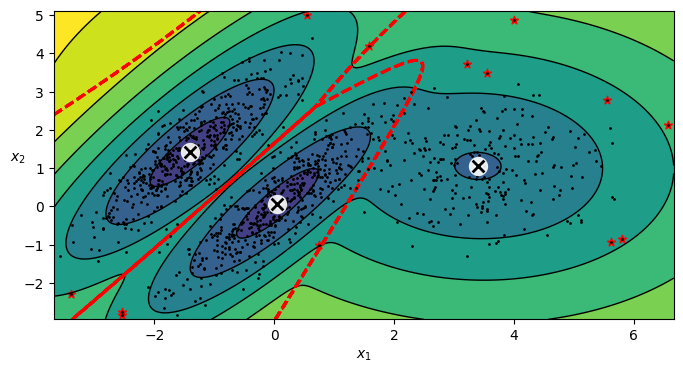

In [38]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color="r", marker="*")
plt.ylim(top=5.1)

plt.show()

In [44]:
from sklearn.covariance import EllipticEnvelope

EllipticEnvelope?

Init signature:
EllipticEnvelope(
    *,
    store_precision=True,
    assume_centered=False,
    support_fraction=None,
    contamination=0.1,
    random_state=None,
)
Docstring:     
An object for detecting outliers in a Gaussian distributed dataset.

Read more in the :ref:`User Guide <outlier_detection>`.

Parameters
----------
store_precision : bool, default=True
    Specify if the estimated precision is stored.

assume_centered : bool, default=False
    If True, the support of robust location and covariance estimates
    is computed, and a covariance estimate is recomputed from it,
    without centering the data.
    Useful to work with data whose mean is significantly equal to
    zero but is not exactly zero.
    If False, the robust location and covariance are directly computed
    with the FastMCD algorithm without additional treatment.

support_fraction : float, default=None
    The proportion of points to be included in the support of the raw
    MCD estimate. If None, the m

## Selecting the Number of Clusters

### Likelihood Function

In [5]:
from scipy.stats import norm

x_val = 2.5
std_val = 1.3
x_range = [-6, 4]
x_proba_range = [-2, 2]
stds_range = [1, 2]

xs = np.linspace(x_range[0], x_range[1], 501)
stds = np.linspace(stds_range[0], stds_range[1], 501)
Xs, Stds = np.meshgrid(xs, stds)
Z = 2 * norm.pdf(Xs - 1.0, 0, Stds) + norm.pdf(Xs + 4.0, 0, Stds)
# We first sum Z row-wise (for each standard deviation), then reshape into column vector. We need to take an account for the width of the intervals, as we approximate a continuous function discretely.
Z = Z / Z.sum(axis=1)[:, np.newaxis] / (xs[1] - xs[0])

In [6]:
x_example_idx = (xs >= x_val).argmax()  # index of the first value >= x_val
max_idx = Z[:, x_example_idx].argmax()
max_val = Z[:, x_example_idx].max()
std_example_idx = (stds >= std_val).argmax()
x_range_min_idx = (xs >= x_proba_range[0]).argmax()
x_range_max_idx = (xs >= x_proba_range[1]).argmax()
log_max_idx = np.log(Z[:, x_example_idx]).argmax()
log_max_val = np.log(Z[:, x_example_idx]).max()

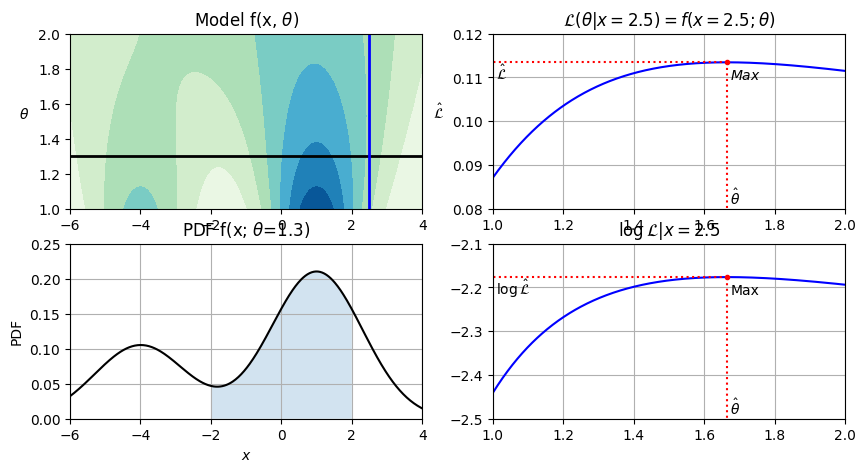

In [7]:
plt.figure(figsize=(10, 5))

plt.subplot(221)
plt.contourf(Xs, Stds, Z, cmap="GnBu")
plt.plot([-6, 4], [std_val, std_val], "k-", linewidth=2)
plt.plot([x_val, x_val], [1, 2], "b-", linewidth=2)
plt.ylabel(r"$\theta$", rotation=0, labelpad=10)
plt.title(r"Model f(x, $\theta$)")

plt.subplot(222)
plt.plot(stds, Z[:, x_example_idx], "b-")
plt.plot(stds[max_idx], max_val, "r.")
plt.plot([stds[max_idx], stds[max_idx]], [0, max_val], "r:")
plt.plot([0, stds[max_idx]], [max_val, max_val], "r:")
plt.text(stds[max_idx] + 0.01, 0.081, r"$\hat{\theta}$")
plt.text(stds[max_idx] + 0.01, max_val - 0.004, r"$Max$")
plt.text(1.01, max_val - 0.004, r"$\hat{\mathcal{L}}$")
plt.ylabel(r"$\hat{\mathcal{L}}$", rotation=0, labelpad=10)
plt.title(rf"$\mathcal{{L}}(\theta|x={x_val})=f(x={x_val}; \theta)$")
plt.grid()
plt.axis([1, 2, 0.08, 0.12])

plt.subplot(223)
plt.plot(xs, Z[std_example_idx], "k-")
plt.fill_between(
    xs[x_range_min_idx : x_range_max_idx + 1],
    Z[std_example_idx, x_range_min_idx : x_range_max_idx + 1],
    alpha=0.2,
)
plt.xlabel(r"$x$")
plt.ylabel("PDF")
plt.title(rf"PDF f(x; $\theta$={std_val})")
plt.grid()
plt.axis([-6, 4, 0, 0.25])

plt.subplot(224)
plt.plot(stds, np.log(Z[:, x_example_idx]), "b-")
plt.plot(stds[log_max_idx], log_max_val, "r.")
plt.plot([stds[log_max_idx], stds[log_max_idx]], [-5, log_max_val], "r:")
plt.plot([0, stds[log_max_idx]], [log_max_val, log_max_val], "r:")
plt.text(1.01, log_max_val - 0.04, r"$\log\hat{\mathcal{L}}$")
plt.text(stds[log_max_idx] + 0.01, log_max_val - 0.04, "Max")
plt.text(stds[log_max_idx] + 0.01, -2.49, r"$\hat{\theta}$")
plt.title(rf"$\log\mathcal{{L}}|x={x_val}$")
plt.grid()
plt.axis([1, 2, -2.5, -2.1])

plt.show()